In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Step1: Description of the problem

This is a binary classification problem to detect histopathologic cancer. For the classification of pathology images, a positive case means that the center 32 x 32 px region of a patch contains at least one pixel of tumor tissue and a negative case means there is no tumor tissue or the tumor tissue is in the outer region of the patch. For the size of the data, there are 220025 images in the training data and 2 columns, the id of the images and the label of the images. Because this is a huge project, I just focused on the 1% (N = 2200) to show the process of using a convolutional neural network to build the model. For the 2200 cases, I chose 1100 positive cases and 1100 negative cases. 

In [57]:
import pandas as pd
import os

BASE = "/kaggle/input/histopathologic-cancer-detection"
WORK = "/kaggle/working"

labels = pd.read_csv(f"{BASE}/train_labels.csv")   # shape of training data
print("Total images:", len(labels))
labels.head()

Total images: 220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [58]:
# select 1% of data for training: 0.5% from each class 
n = int(len(labels) * 0.005)

pos = labels.query("label == 1").sample(n, random_state=42)
neg = labels.query("label == 0").sample(n, random_state=42)
subset_labels = pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced 1% subset: {len(subset_labels)} images ({subset_labels.label.sum()} positive)")

subset_labels.to_csv(f"{WORK}/train_labels_subset.csv", index=False)
subset_labels.head()

Balanced 1% subset: 2200 images (1100 positive)


,id,label
0,3b0418f11283d1f8bdf1080a091c05b8d733c8bb,0
1,6942994477c5895049b91d205d8027734f4378fb,0
2,f992011b383e9fa5a5edbf40926e7e8d50d00f7a,0
3,abb850b23bb0356f7590673a376683a6f6238716,0
4,4c742e40b39d5029cabad1772bc892112eabfad9,0


In [59]:
import shutil
import os
from tqdm.notebook import tqdm

os.makedirs(f"{WORK}/train_subset", exist_ok=True)

# copy the training data
for img_id in tqdm(subset_labels["id"], desc="Copying subset"):
    src = f"{BASE}/train/{img_id}.tif"
    dst = f"{WORK}/train_subset/{img_id}.tif"
    shutil.copy(src, dst)

Copying subset:   0%|          | 0/2200 [00:00<?, ?it/s]

In [60]:
import glob
# check the files for the analysis
print("Subset images:", len(glob.glob(f'{WORK}/train_subset/*.tif')))

Subset images: 22002


In [62]:
#Subset training data and labels
DATA_DIR = "/kaggle/working/train_subset"
LABELS_CSV = "/kaggle/working/train_labels_subset.csv"

In [63]:
BASE = "/kaggle/input/histopathologic-cancer-detection"
WORK = "/kaggle/working"
DATA_DIR = f"{WORK}/train_subset"
LABELS_CSV = f"{WORK}/train_labels_subset.csv"

# load the subset
subset = pd.read_csv(LABELS_CSV)
print("Subset shape / label counts:", subset.shape, subset.label.value_counts().to_dict())


def img_path(img_id):
    p1 = f"{DATA_DIR}/{img_id}.tif"       # your small copied set
    p2 = f"{BASE}/train/{img_id}.tif"     # original full dataset
    return p1 if os.path.exists(p1) else p2

subset["filepath"] = subset["id"].apply(img_path)
      
missing = (~subset["filepath"].apply(os.path.exists)).sum()
print(f"Missing tiles: {missing}")

subset.head()

Subset shape / label counts: (2200, 2) {0: 1100, 1: 1100}
Missing tiles: 0


,id,label,filepath
0,3b0418f11283d1f8bdf1080a091c05b8d733c8bb,0,/kaggle/working/train_subset/3b0418f11283d1f8b...
1,6942994477c5895049b91d205d8027734f4378fb,0,/kaggle/working/train_subset/6942994477c589504...
2,f992011b383e9fa5a5edbf40926e7e8d50d00f7a,0,/kaggle/working/train_subset/f992011b383e9fa5a...
3,abb850b23bb0356f7590673a376683a6f6238716,0,/kaggle/working/train_subset/abb850b23bb0356f7...
4,4c742e40b39d5029cabad1772bc892112eabfad9,0,/kaggle/working/train_subset/4c742e40b39d5029c...


Step 2: Exploratory Data Analysis

Because the images will take up a large storage, I imported them from the file paths. I paid attention to the match of the chosen training data and the labels of these chosen data. Because there are only variables, image ID and label, in the data, it is not very meaningful to use some visualization tools, such as a histogram. I visualized their numbers and also randomly selected 6 cases to show the images. My plan of analysis is to build a CNN model to first pick up features from these images and then predict the label.


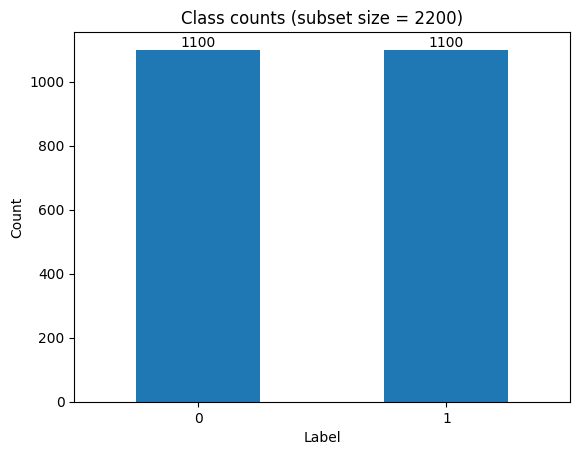

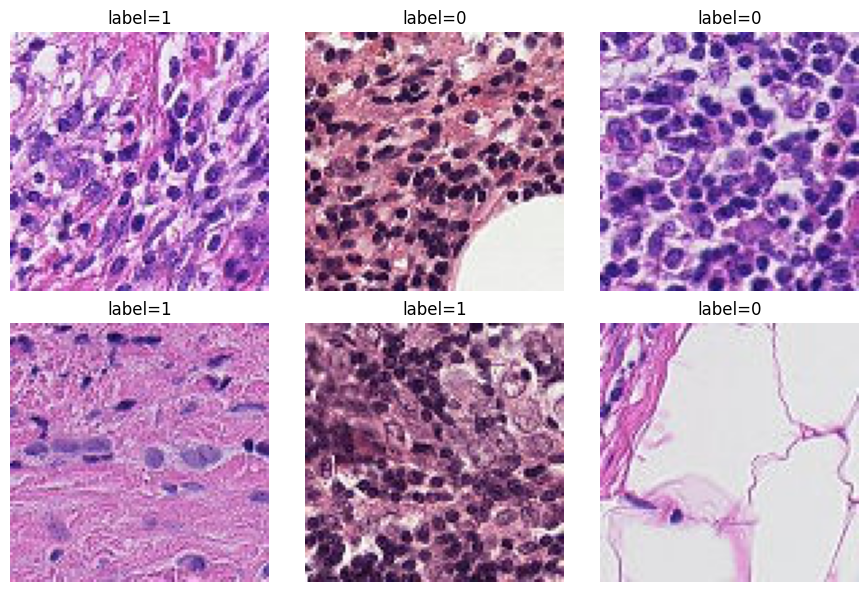

In [64]:
import matplotlib.pyplot as plt
from PIL import Image

counts = subset.label.value_counts().sort_index()  # order: 0, 1
ax0 = counts.plot(kind="bar", rot=0, title=f"Class counts (subset size = {len(subset)})")

try:
    ax0.bar_label(ax0.containers[0])
except Exception:
    pass
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


samp = subset.sample(6, random_state=0)
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for axi, (_, r) in zip(axes.ravel(), samp.iterrows()):
    img = Image.open(r["filepath"]).convert("RGB")
    axi.imshow(img)
    axi.set_title(f"label={r.label}")
    axi.axis("off")
plt.tight_layout()
plt.show()

Step 3: Model architecture

I choose the image size 96x96, batch size 128, epoch 5, and number of workers 2 as the hyperparameters. Of course, these hyperparameters can be changed. For example, image size 96 x 96 may take a long time to train the model, but image size 48 x 48 may not capture enough useful information from the images. Epoch 5 is a tiny number in epochs. 

First, I resized the images to the same size 96 x 96, then randomly flipped top-down, left-right, and rotated them in different angles. Finally, I transformed them to be suitable for PyTorch. 

The SmallCNN model consists of three convolutional blocks that progressively extract hierarchical features while reducing spatial dimensions: the first block applies two 3×3 convolution layers with 32 filters followed by max pooling (reducing the image from 96×96 to 48×48), the second block doubles the channels to 64 with another pair of convolutions and max pooling (48×48 to 24×24), and the third block increases depth to 128 filters, ending with an adaptive average pooling layer that compresses each feature map to a single value. The flattened feature vector is then passed through two fully connected layers with ReLU activations and 0.3 dropout for regularization, producing a single output neuron representing the probability of the positive class through a sigmoid function during training or evaluation.

The task is largely textual (e.g., nuclei density, gland borders, chromatin granularity). The SmallCNN fits well because stacked 3x3 convolutions and ReLU activation function can help learn textures at multiple scales. Two max-pooling stages downsample to keep computation low. It is fast to train. 

I also tested the results when the epoch was set to 10 to see whether the model results became stable. 

In [67]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
IMG_SIZE, BATCH, EPOCHS, NUM_WORKERS = 96, 128, 5, 2

# Split
train_df, val_df = train_test_split(subset, test_size=0.10, stratify=subset["label"], random_state=42)

# Transforms
tfm_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # resize images to the same size
    transforms.RandomHorizontalFlip(),   # randonly flip images left-right
    transforms.RandomVerticalFlip(),     # randomly flip images top-bottom
    transforms.RandomRotation(20),       # rotate the images by a randon angle (-20 to 20)
    transforms.ToTensor(),
])
tfm_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Pytorch dataset
class HistoDS(Dataset):
    def __init__(self, df, tfm):
        self.df = df.reset_index(drop=True); self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r["filepath"]).convert("RGB")
        x = self.tfm(img)
        y = torch.tensor(r["label"], dtype=torch.float32)
        return x, y

# Dataloader creation
train_dl = DataLoader(HistoDS(train_df, tfm_train), batch_size=BATCH, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(HistoDS(val_df,   tfm_val  ), batch_size=BATCH, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

## CNN architecture
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ch=[32,64,128]     # the number of output channels in each block
        self.net = nn.Sequential(
            # each image has 3 channels, size 96 x 96, 32 filters, kernel size 3 x 3
            # stride 1, padding 1, ReLu activation, keep the size constant
            nn.Conv2d(3,ch[0],3,padding=1), nn.ReLU(True), 
            nn.Conv2d(ch[0],ch[0],3,padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),                # 96 x 96 -> 48 x 48

            # take the previous 32 channels, output 64 channels
            nn.Conv2d(ch[0],ch[1],3,padding=1), nn.ReLU(True),
            nn.Conv2d(ch[1],ch[1],3,padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),                # 48 x 48 -> 24 x 24

            # take the previous 64 channels, output 128 channels
            nn.Conv2d(ch[1],ch[2],3,padding=1), nn.ReLU(True),
            nn.Conv2d(ch[2],ch[2],3,padding=1), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1),        # -> (128,1,1)

            # flatten the channel, dropout = 0.3, fully-connected, output for a binary classification
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(ch[2],128), nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(128,1)
        )
    def forward(self,x): return self.net(x)

model = SmallCNN().to(DEVICE)

# Class weighting (in case the numbers of positive and negative cases are not equal)
pos = (train_df.label==1).sum(); neg = (train_df.label==0).sum()
pos_weight = torch.tensor([neg/max(pos,1)], device=DEVICE)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

def train_epoch():
    model.train(); tot=0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True).unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            logit = model(xb); loss = criterion(logit, yb)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        tot += loss.item() * xb.size(0)
    return tot / len(train_dl.dataset)

@torch.no_grad()
def eval_epoch():
    model.eval(); tot=0.0; P=[]; T=[]
    for xb, yb in val_dl:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True).unsqueeze(1)
        logit = model(xb); loss = criterion(logit, yb)
        tot += loss.item() * xb.size(0)
        P.append(torch.sigmoid(logit).cpu().numpy().ravel())
        T.append(yb.cpu().numpy().ravel())
    p = np.concatenate(P); t = np.concatenate(T)
    auc = roc_auc_score(t, p) if len(np.unique(t))>1 else float("nan")
    return tot/len(val_dl.dataset), auc

/tmp/ipykernel_48/536299236.py:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))


/tmp/ipykernel_48/536299236.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01 | train 0.6921 | valid 0.6859 | AUC 0.7493


/tmp/ipykernel_48/536299236.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 02 | train 0.6690 | valid 0.6940 | AUC 0.7650


/tmp/ipykernel_48/536299236.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 03 | train 0.6676 | valid 0.6559 | AUC 0.7640


/tmp/ipykernel_48/536299236.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 04 | train 0.5787 | valid 0.6248 | AUC 0.8047


/tmp/ipykernel_48/536299236.py:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 05 | train 0.5193 | valid 0.5538 | AUC 0.8073
Best AUC: 0.8072727272727273


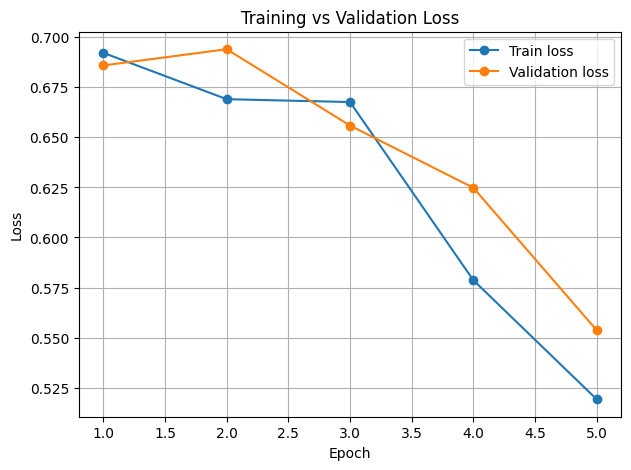

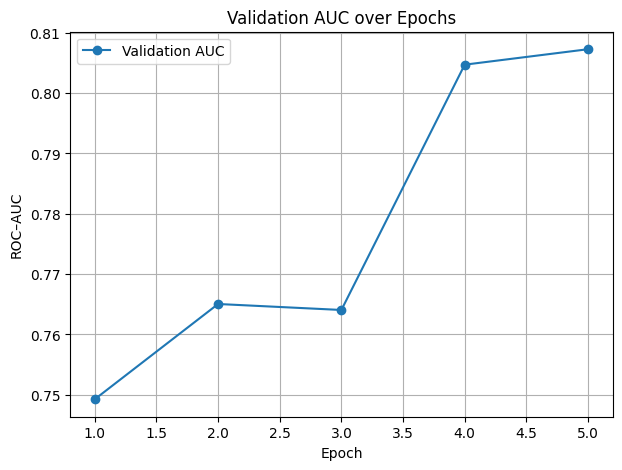

In [68]:
import matplotlib.pyplot as plt

history = {"epoch": [], "train_loss": [], "val_loss": [], "val_auc": []}

best_auc = -1
for e in range(1, EPOCHS + 1):
    tr = train_epoch()
    vl, auc = eval_epoch()

    history["epoch"].append(e)
    history["train_loss"].append(tr)
    history["val_loss"].append(vl)
    history["val_auc"].append(auc)

    print(f"Epoch {e:02d} | train {tr:.4f} | valid {vl:.4f} | AUC {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), f"{WORK}/best.pt")

print("Best AUC:", best_auc)


plt.figure(figsize=(7,5))
plt.plot(history["epoch"], history["train_loss"], marker="o", label="Train loss")
plt.plot(history["epoch"], history["val_loss"], marker="o", label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(7,5))
plt.plot(history["epoch"], history["val_auc"], marker="o", label="Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC–AUC")
plt.title("Validation AUC over Epochs")
plt.grid(True)
plt.legend()
plt.show()

Step 4: Results and Analysis

When the epoch was 5, the training loss and the validation loss both decreased and they did not show stability. However the AUC score steadily increases. 

When the epoch was 10, the training loss became stable after epoch was 6, and the validation loss first decreased and then started to increase when epoch was 6. 

Regarding the hyperparameter tuning, the epoch might be set to 6. 

When epoch was 6, the training loss was around 0.50, the validation loss was around 0.53, and the AUC score was around 0.81, suggesting that model performed reasonally well and did not strongly indicate overfitting. This is good, considering that I just used 1% of the training data.

Because I just chose 1% of the total data, the results here might not be generalized to the whole data. 

In [70]:
IMG_SIZE, BATCH, EPOCHS, NUM_WORKERS = 96, 128, 10, 2

# Split
train_df, val_df = train_test_split(subset, test_size=0.10, stratify=subset["label"], random_state=42)

# Transforms
tfm_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # resize images to the same size
    transforms.RandomHorizontalFlip(),   # randonly flip images left-right
    transforms.RandomVerticalFlip(),     # randomly flip images top-bottom
    transforms.RandomRotation(20),       # rotate the images by a randon angle (-20 to 20)
    transforms.ToTensor(),
])
tfm_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# Pytorch dataset
class HistoDS(Dataset):
    def __init__(self, df, tfm):
        self.df = df.reset_index(drop=True); self.tfm = tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        r = self.df.iloc[i]
        img = Image.open(r["filepath"]).convert("RGB")
        x = self.tfm(img)
        y = torch.tensor(r["label"], dtype=torch.float32)
        return x, y

# Dataloader creation
train_dl = DataLoader(HistoDS(train_df, tfm_train), batch_size=BATCH, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(HistoDS(val_df,   tfm_val  ), batch_size=BATCH, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ch=[32,64,128]     # the number of output channels in each block
        self.net = nn.Sequential(
            # each image has 3 channels, size 96 x 96, 32 filters, kernel size 3 x 3
            # stride 1, padding 1, ReLu activation, keep the size constant
            nn.Conv2d(3,ch[0],3,padding=1), nn.ReLU(True), 
            nn.Conv2d(ch[0],ch[0],3,padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),                # 96 x 96 -> 48 x 48

            # take the previous 32 channels, output 64 channels
            nn.Conv2d(ch[0],ch[1],3,padding=1), nn.ReLU(True),
            nn.Conv2d(ch[1],ch[1],3,padding=1), nn.ReLU(True),
            nn.MaxPool2d(2),                # 48 x 48 -> 24 x 24

            # take the previous 64 channels, output 128 channels
            nn.Conv2d(ch[1],ch[2],3,padding=1), nn.ReLU(True),
            nn.Conv2d(ch[2],ch[2],3,padding=1), nn.ReLU(True),
            nn.AdaptiveAvgPool2d(1),        # -> (128,1,1)

            # flatten the channel, dropout = 0.3, fully-connected, output for a binary classification
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(ch[2],128), nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(128,1)
        )
    def forward(self,x): return self.net(x)

model = SmallCNN().to(DEVICE)

# Class weighting (in case the numbers of positive and negative cases are not equal)
pos = (train_df.label==1).sum(); neg = (train_df.label==0).sum()
pos_weight = torch.tensor([neg/max(pos,1)], device=DEVICE)
criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

def train_epoch():
    model.train(); tot=0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True).unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            logit = model(xb); loss = criterion(logit, yb)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        tot += loss.item() * xb.size(0)
    return tot / len(train_dl.dataset)

@torch.no_grad()
def eval_epoch():
    model.eval(); tot=0.0; P=[]; T=[]
    for xb, yb in val_dl:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True).unsqueeze(1)
        logit = model(xb); loss = criterion(logit, yb)
        tot += loss.item() * xb.size(0)
        P.append(torch.sigmoid(logit).cpu().numpy().ravel())
        T.append(yb.cpu().numpy().ravel())
    p = np.concatenate(P); t = np.concatenate(T)
    auc = roc_auc_score(t, p) if len(np.unique(t))>1 else float("nan")
    return tot/len(val_dl.dataset), auc

/tmp/ipykernel_48/1422928196.py:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 01 | train 0.6926 | valid 0.6889 | AUC 0.6845


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 02 | train 0.6850 | valid 0.6571 | AUC 0.7231


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 03 | train 0.6695 | valid 0.6686 | AUC 0.7717


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 04 | train 0.6370 | valid 0.5927 | AUC 0.7872


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 05 | train 0.5549 | valid 0.5398 | AUC 0.7973


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 06 | train 0.5061 | valid 0.5334 | AUC 0.8092


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 07 | train 0.4990 | valid 0.5892 | AUC 0.7844


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 08 | train 0.4904 | valid 0.5465 | AUC 0.8068


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 09 | train 0.4813 | valid 0.5336 | AUC 0.8076


/tmp/ipykernel_48/1422928196.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):


Epoch 10 | train 0.4924 | valid 0.6164 | AUC 0.8168
Best AUC: 0.8167768595041321


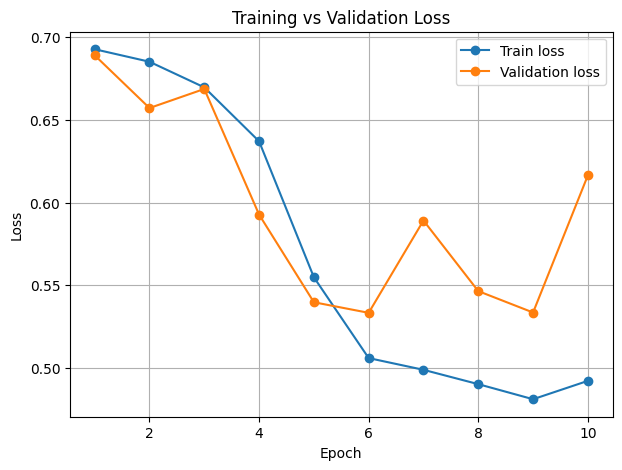

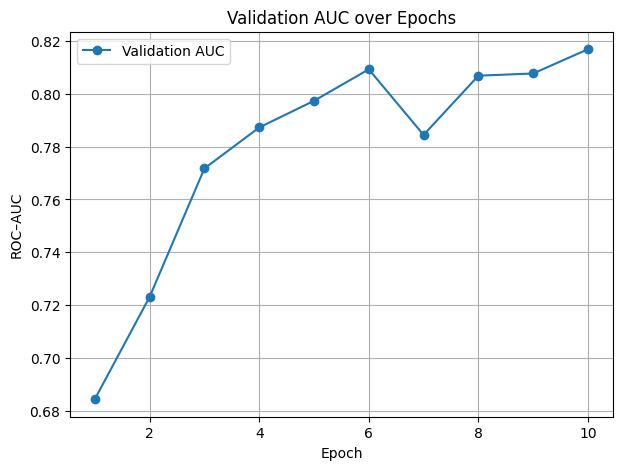

In [71]:
history = {"epoch": [], "train_loss": [], "val_loss": [], "val_auc": []}

best_auc = -1
for e in range(1, EPOCHS + 1):
    tr = train_epoch()
    vl, auc = eval_epoch()

    history["epoch"].append(e)
    history["train_loss"].append(tr)
    history["val_loss"].append(vl)
    history["val_auc"].append(auc)

    print(f"Epoch {e:02d} | train {tr:.4f} | valid {vl:.4f} | AUC {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        torch.save(model.state_dict(), f"{WORK}/best.pt")

print("Best AUC:", best_auc)

plt.figure(figsize=(7,5))
plt.plot(history["epoch"], history["train_loss"], marker="o", label="Train loss")
plt.plot(history["epoch"], history["val_loss"], marker="o", label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(7,5))
plt.plot(history["epoch"], history["val_auc"], marker="o", label="Validation AUC")
plt.xlabel("Epoch")
plt.ylabel("ROC–AUC")
plt.title("Validation AUC over Epochs")
plt.grid(True)
plt.legend()
plt.show()

Step 5: Conclusion

I just used 1% of the total data to train the model and split the data into training and validation sets. I use a simple CNN architecture to capture the features of different images. The training model performed reasonably well. 

I do think that increasing the number of epochs may help show the stability of training loss and validation loss and then give us a better impression of the model performance. 

In the future, I wish I could try to use the total dataset because even 1% of the data could lead to a reasonably good performance of a training model. I am curious to see the performance using the total dataset. 

In terms of learning and takeaways, deep learning models, especially when used on images, really take a long time to fit and you can try different models based on your time and the available resources, such as GPU.